In [1]:
import os 
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data.Group == 'AD') | (data.Group == 'CN'))]
    return data


In [3]:
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)


In [4]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data(path)
y_data.head()


,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN


# Data preparation & splitting 

In [5]:
from tensorflow.keras.utils import to_categorical


def Data_preparation(Y):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename).get_fdata()
            
            # On regarde si les hippocampes concernés sont CN ou AD
            if Y['Group'][index] == 'AD':
                Y_val = 1
            elif Y['Group'][index] == 'CN':
                Y_val = 0
            
            # hippocampe n°1 :
            
            hipp1 = img_n_mmni[40:80,90:130,40:80]
            X_data.append(hipp1)
            Y_data.append(Y_val)
                
            # flip sur l'axe 0 de l'hippocampe 1
            hipp1_flipped = np.flip(hipp1, 0)
            X_data.append(hipp1_flipped)
            Y_data.append(Y_val)
            
            
            # hippocampe n°2 :
            
            hipp2 = img_n_mmni[100:140,90:130,40:80]
            X_data.append(hipp2)
            Y_data.append(Y_val)
            
            # flip sur l'axe 0 de l'hippocampe 2
            hipp2_flipped = np.flip(hipp2, 0)
            X_data.append(hipp2_flipped)
            Y_data.append(Y_val)
            
        else:
            Y.drop(index, inplace=True)
        
    X_data = np.array(X_data)   
    return X_data, Y_data





2022-12-14 14:34:40.435548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 14:34:41.275468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/coleger/miniconda3/envs/tf/lib/
2022-12-14 14:34:41.275608: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/coleger/miniconda3/envs/tf/lib/
2022-12-14 14:34:41.275613: W tensorflow/compiler/tf

In [6]:
X_data, Y_data = Data_preparation(y_data)
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(1676, 40, 40, 40)
1676


In [7]:
print(X_data[0].shape)
print(X_data[1].shape)



(40, 40, 40)
(40, 40, 40)


In [8]:
# on garde seulement une colonne pour y 
y_data = np.argmax(Y_data, axis= 1)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=49) 

print("Data splited, length of training data is: ", len(X_train))
print("Data splited, length of test data is: ", len(X_test))

Data splited, length of training data is:  1340
Data splited, length of test data is:  336


# Creation and evaluation of Conv3D model

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization

model = Sequential()
# Couches de convolution + MaxPooling
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(40,40,40,1)))
# input shape = (batch_size, channels, dim1, dim2,dim3)
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.3))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.3))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.3))
# Couches de classification
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

    

2022-12-14 14:35:49.570849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 38, 38, 38, 32)    896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 19, 19, 19, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 19, 19, 19, 32)   128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 19, 19, 19, 32)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 17, 17, 17, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 8, 8, 8, 64)      0

2022-12-14 14:35:49.590096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 14:35:49.590260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 14:35:49.594149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 14:35:49.605390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

# Training and evaluation with 80% of CN et AD data 

In [11]:
import tensorflow as tf
# ajout d'un early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[callback],batch_size=16)

Epoch 1/100


2022-12-14 14:35:52.432594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-14 14:35:53.264218: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-14 14:35:54.117045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


84/84 [==============================] - 7s 42ms/step - loss: 0.6953 - accuracy: 0.7067 - val_loss: 0.5875 - val_accuracy: 0.6964
Epoch 2/100
84/84 [==============================] - 3s 35ms/step - loss: 0.5718 - accuracy: 0.7388 - val_loss: 0.4563 - val_accuracy: 0.8155
Epoch 3/100
84/84 [==============================] - 3s 35ms/step - loss: 0.4866 - accuracy: 0.7806 - val_loss: 0.6662 - val_accuracy: 0.6310
Epoch 4/100
84/84 [==============================] - 3s 35ms/step - loss: 0.4346 - accuracy: 0.7978 - val_loss: 0.8451 - val_accuracy: 0.5119
Epoch 5/100
84/84 [==============================] - 3s 36ms/step - loss: 0.3746 - accuracy: 0.8396 - val_loss: 0.3980 - val_accuracy: 0.8393
Epoch 6/100
84/84 [==============================] - 3s 35ms/step - loss: 0.3316 - accuracy: 0.8522 - val_loss: 1.1786 - val_accuracy: 0.6935
Epoch 7/100
84/84 [==============================] - 3s 35ms/step - loss: 0.3155 - accuracy: 0.8672 - val_loss: 0.8499 - val_accuracy: 0.7411
Epoch 8/100
84/84 

# Plotting metrics 

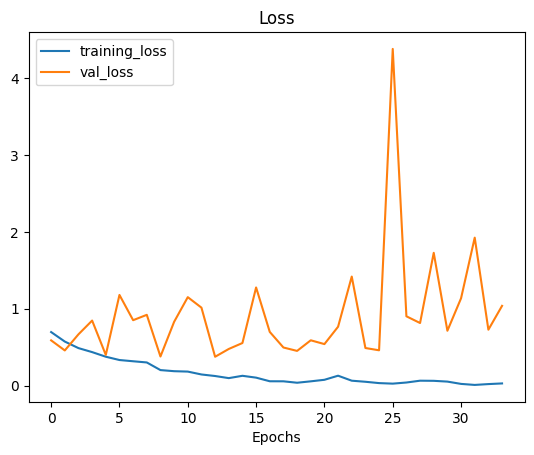

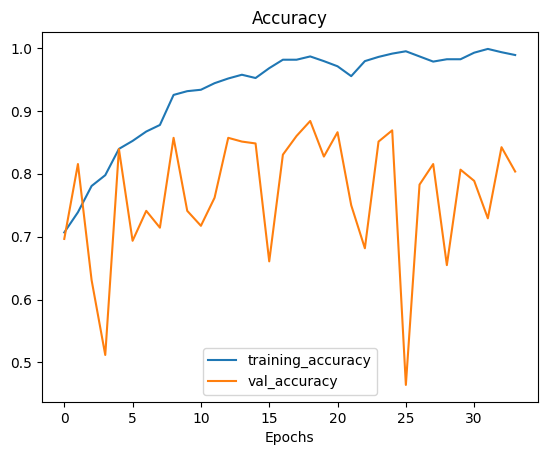

In [12]:
def plot_loss_curves(history):
    
      
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history)

In [13]:
best_val_accuracy = np.max(history.history['val_accuracy'])
print(' Best val_accuracy value : {} '.format(best_val_accuracy))

 Best val_accuracy value : 0.8839285969734192 


# Training with whole AD and CN data

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization

model2 = Sequential()
# Couches de convolution + MaxPooling
model2.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(40,40,40,1)))
# input shape = (batch_size, channels, dim1, dim2,dim3)
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization(center=True, scale=True))
model2.add(Dropout(0.3))
model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization(center=True, scale=True))
model2.add(Dropout(0.3))
model2.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization(center=True, scale=True))
model2.add(Dropout(0.3))
# Couches de classification
model2.add(Flatten())
model2.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model2.summary()

    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 38, 38, 38, 32)    896       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 19, 19, 19, 32)   0         
 3D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 19, 19, 19, 32)   128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 19, 19, 19, 32)    0         
                                                                 
 conv3d_4 (Conv3D)           (None, 17, 17, 17, 64)    55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 8, 8, 64)     

In [15]:
history2 = model2.fit(X_data, y_data, epochs=20)

Epoch 1/20
53/53 [==============================] - 4s 53ms/step - loss: 0.6875 - accuracy: 0.6844
Epoch 2/20
53/53 [==============================] - 3s 53ms/step - loss: 0.5216 - accuracy: 0.7625
Epoch 3/20
53/53 [==============================] - 3s 53ms/step - loss: 0.4589 - accuracy: 0.7942
Epoch 4/20
53/53 [==============================] - 3s 53ms/step - loss: 0.4150 - accuracy: 0.8138
Epoch 5/20
53/53 [==============================] - 3s 53ms/step - loss: 0.3619 - accuracy: 0.8455
Epoch 6/20
53/53 [==============================] - 3s 53ms/step - loss: 0.3262 - accuracy: 0.8604
Epoch 7/20
53/53 [==============================] - 3s 53ms/step - loss: 0.2940 - accuracy: 0.8687
Epoch 8/20
53/53 [==============================] - 3s 54ms/step - loss: 0.2386 - accuracy: 0.8974
Epoch 9/20
53/53 [==============================] - 3s 53ms/step - loss: 0.2039 - accuracy: 0.9129
Epoch 10/20
53/53 [==============================] - 3s 53ms/step - loss: 0.1791 - accuracy: 0.9224
Epoch 11/

# Testing with pMCI et sMCI data 

- pMCI ~ AD ==1
- sMCI ~ CN ==0

In [16]:
def get_data_MCI(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group','Conversion'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data['Conversion'] == 1) | (data['Conversion'] == 2) | (data['Conversion'] == 3) | (data['Conversion'] == 4))]
    return data


In [17]:
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)


In [18]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data_MCI(path)
y_data.head()


,Rooster ID,Group,Conversion
Subject ID,,,
002_S_0729,729,MCI,3
002_S_0782,782,MCI,4
002_S_0954,954,MCI,3
002_S_1070,1070,MCI,3
002_S_1155,1155,MCI,4


# Data preparation & splitting 

In [19]:
from tensorflow.keras.utils import to_categorical


def Data_preparation_MCI(Y):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename).get_fdata()
            
            # hippocampe n°1 :
            
            hipp1 = img_n_mmni[40:80,90:130,40:80]
            X_data.append(hipp1)
            if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                Y_data.append(1)
            elif Y['Conversion'][index] == 4 : #sMCI
                Y_data.append(0)
            
            
            # hippocampe n°2 :
            
            hipp2 = img_n_mmni[100:140,90:130,40:80]
            X_data.append(hipp2)
            if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                Y_data.append(1)
            elif Y['Conversion'][index] == 4 : #sMCI
                Y_data.append(0)    
            1
        else:
            Y.drop(index, inplace=True)
        
    X_data = np.array(X_data)   
    return X_data, Y_data





In [20]:
X_data, Y_data = Data_preparation_MCI(y_data)
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(600, 40, 40, 40)
600


In [21]:
# on garde seulement une colonne pour y 
y_data = np.argmax(Y_data, axis= 1)

## Prédiction (pour chaque hippocampe) 

In [22]:
ypred_raw_model1 = model.predict(X_data)
ypred_raw_model2 = model2.predict(X_data)

19/19 [==============================] - 0s 17ms/step


In [23]:
ypred_model1 = np.where(ypred_raw_model1 > 0.5, 1, 0)
ypred_model2 = np.where(ypred_raw_model2 > 0.5, 1, 0)

In [24]:
from sklearn.metrics import accuracy_score

acc_model1 = accuracy_score(ypred_model1, y_data)
acc_model2 = accuracy_score(ypred_model2, y_data)

print('accuracy on MCI data based on CN and AD training with model 1: {} '.format(acc_model1))
print('accuracy on MCI data based on CN and AD training with model 2: {} '.format(acc_model2))

accuracy on MCI data based on CN and AD training with model 1: 0.645 
accuracy on MCI data based on CN and AD training with model 2: 0.665 


## Prédiction (pour chaque hippocampe) 

Comme on ajoute à chaque fois les deux hippocampes du même sujet à la suite, les labels sont les mêmes pour toutes les paires de données et on en prend que 1 sur 2

In [25]:
y_real_data = y_data[::2]
print(y_real_data.shape)

(300,)


Pour la prédiction pour un patient, on prend la moyenne issue de l'activation sigmoid du réseau de neurones pour les deux hippocampes 

In [26]:
y_pred_hipp1_model1 = ypred_raw_model1[::2]
y_pred_hipp2_model1 =  ypred_raw_model1[1::2]
y_real_pred_raw_model1 = (y_pred_hipp1_model1 + y_pred_hipp2_model1)/2
y_real_pred_model1 = np.where(y_real_pred_raw_model1 > 0.5, 1,0)

y_pred_hipp1_model2 = ypred_raw_model2[::2]
y_pred_hipp2_model2 =  ypred_raw_model2[1::2]
y_real_pred_raw_model2 = (y_pred_hipp1_model2 + y_pred_hipp2_model2)/2
y_real_pred_model2 = np.where(y_real_pred_raw_model2 > 0.5, 1,0)

In [27]:
acc_model1 = accuracy_score(y_real_pred_model1, y_real_data)
acc_model2 = accuracy_score(y_real_pred_model2, y_real_data)

print('accuracy on MCI data based on CN and AD training with model 1 : {} '.format(acc_model1))
print('accuracy on MCI data based on CN and AD training with model 2 : {} '.format(acc_model2))

accuracy on MCI data based on CN and AD training with model 1 : 0.6766666666666666 
accuracy on MCI data based on CN and AD training with model 2 : 0.6733333333333333 


On garde la meilleure prédiction pour afficher la matrice de confusion

[[ 82  47]
 [ 51 120]]


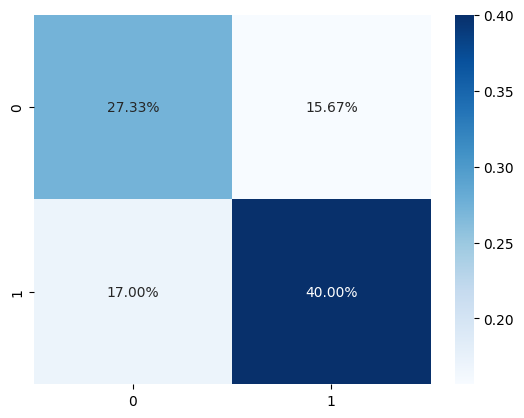

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

names = ['sMCI','pMCI']

cf_matrix = confusion_matrix(y_real_data, y_real_pred_model2)
print(cf_matrix)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

- pMCI ~ AD ==1
- sMCI ~ CN ==0